In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels

In [2]:
from all_models import *

In [3]:
# read fit values
fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
fits_hybrid = pickle.load(open('fit_hybrid_CV_704.pickle', 'rb'))
#fits_eight = pickle.load(open('fit_dual_eight_CV_704.pickle', 'rb'))
#fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
#fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
#fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
#fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))
fits_alpha = pickle.load(open('fit_dual_2alpha_CV_704.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))

curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [16]:
participant = 5
fits_dual[0][participant, -3], fits_single[0][participant, -3]

#min(fits_single[0][participant][-3], fits_dual[0][participant][-3])

(-858.0371294568665, -819.3337795563278)

In [4]:
num_itr = 1
all_A = np.zeros(60)
all_B = np.zeros(60*num_itr)
all_Af = np.zeros(60*num_itr)
all_Bf = np.zeros(60*num_itr)
all_As = np.zeros(60*num_itr)
all_Bs = np.zeros(60*num_itr)
all_alphas = np.zeros(60*num_itr)
all_Vs_single = np.zeros(60*num_itr)
all_Vs_dual = np.zeros(60*num_itr)

for i in range(num_itr):
    all_A[i*60:(i+1)*60] = fits_single[i][:, 0]
    all_B[i*60:(i+1)*60] = fits_single[i][:, 1]
    all_Af[i*60:(i+1)*60] = fits_dual[i][:, 0]
    all_Bf[i*60:(i+1)*60] = fits_dual[i][:, 1]
    all_As[i*60:(i+1)*60] = fits_dual[i][:, 2]
    all_Bs[i*60:(i+1)*60] = fits_dual[i][:, 3]

    all_Vs_single[i*60:(i+1)*60] = fits_single[i][:, -3]
    all_Vs_dual[i*60:(i+1)*60] = fits_dual[i][:, -3]
    all_alphas[i*60:(i+1)*60] = 1- fits_hybrid[i][:, 0]

In [5]:
parameters_df = pd.DataFrame({'Participant_Id': np.tile(range(60), num_itr),
                         'Rotation': np.tile(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 15*num_itr), 
                         'Emphasis': np.tile(['Speed', 'Accuracy'], 30*num_itr),
                         'A': all_A,
                         'B': all_B,
                         'Af': all_Af,
                         'Bf': all_Bf,
                         'As': all_As,
                         'Bs': all_Bs,
                         'V': (all_Vs_single - all_Vs_dual)/(np.mean(all_Vs_single - all_Vs_dual))
                         #'Alpha': all_alphas
                        })


In [6]:
parameter_means = parameters_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()
#parameter_means['ratio'] = (parameter_means['As'] )/(parameter_means['Af'] + parameter_means['As'])
parameter_means['Dual_Selected'] = dual_selected.sort_values(by = 'Participant_Id')['Dual_Selected']

NameError: name 'dual_selected' is not defined

In [56]:
stat.ttest_ind(parameter_means[parameter_means['Dual_Selected'] > 60]['B'], parameter_means[parameter_means['Dual_Selected'] < 40]['B'])

Ttest_indResult(statistic=1.29161981678567, pvalue=0.2026738597519719)

0.1974992056914782

In [8]:
parameter_means_melt = parameter_means.melt(id_vars=['Participant_Id', 'Rotation', 'Emphasis'], var_name='Parameters', value_name='Parameter_Values')

In [23]:
dual_selected = pd.read_csv('dual_selected_testset.csv')

In [27]:
dual_selected['Participant_Id'] = np.concatenate((np.arange(0, 60, 4), np.arange(1, 60, 4), np.arange(2, 60, 4), np.arange(3, 60, 4)))
dual_selected.sort_values(by = 'Participant_Id')['Dual_Selected']

0     23
15    59
30    12
45    89
1     46
16    72
31    97
46    59
2     97
17    95
32    29
47    85
3      3
18    55
33    14
48    93
4     10
19    93
34    21
49    65
5     90
20    94
35    40
50    81
6     50
21    97
36    78
51    17
7     81
22    64
37     7
52    98
8     50
23    52
38     4
53    97
9     86
24    81
39    33
54    89
10    11
25    99
40    11
55    97
11     5
26    11
41    12
56    86
12    59
27    88
42    43
57    86
13    92
28    70
43    75
58    82
14    37
29    88
44    19
59    96
Name: Dual_Selected, dtype: int64

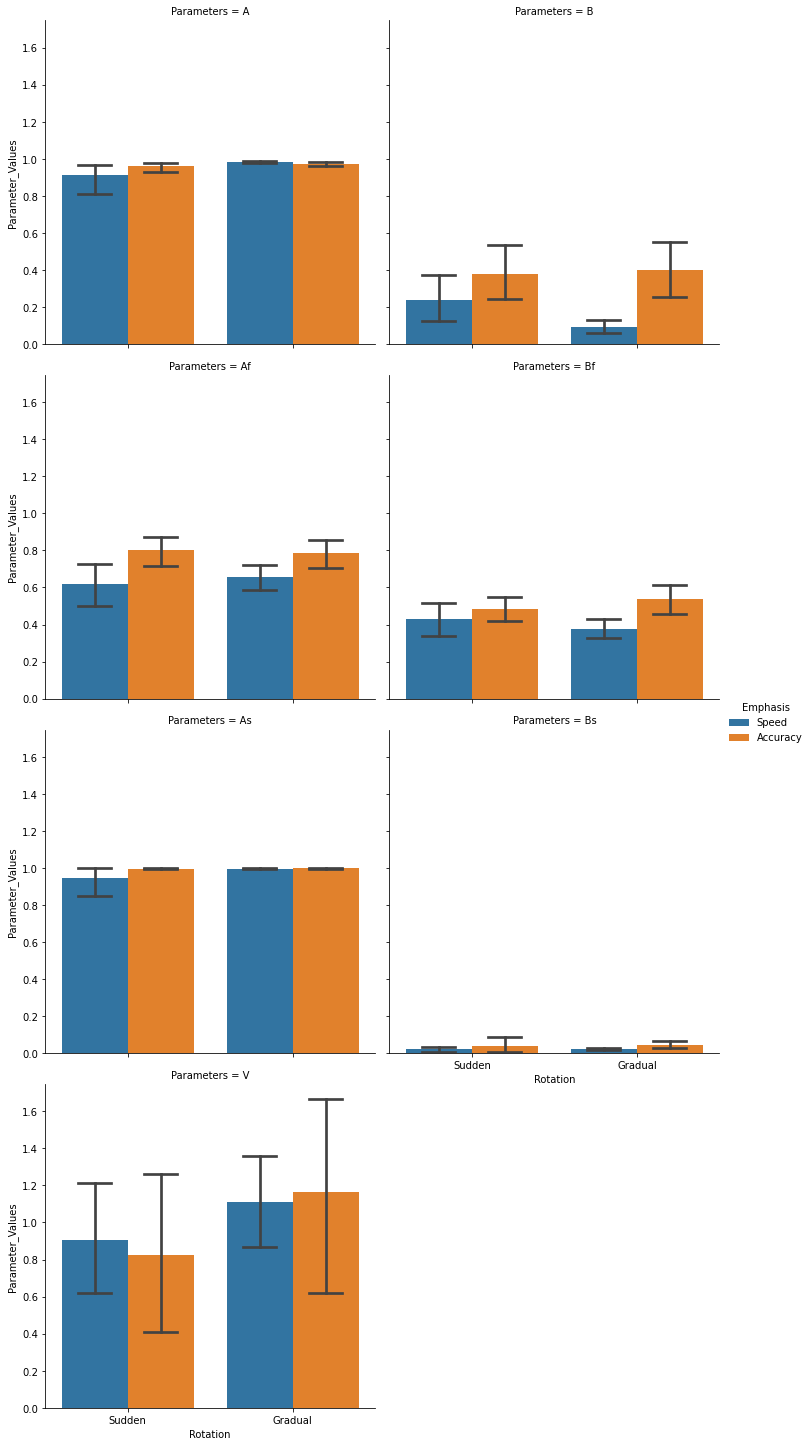

In [9]:
sns.catplot(x = 'Rotation', y = 'Parameter_Values', hue = 'Emphasis', col = 'Parameters', col_wrap = 2,
            data = parameter_means_melt, kind = 'bar', capsize = 0.2)


In [53]:
param = 'V'
stat.ttest_ind(parameter_means[param][parameter_means['Rotation'] == 'Gradual'], parameter_means[param][parameter_means['Rotation'] == 'Sudden'])

Ttest_indResult(statistic=1.3495032500622046, pvalue=0.182419579175782)

In [54]:
model = smf.ols('V~Rotation*Emphasis', data = parameter_means).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,1.124579,1.124579,1.762063,0.189754
Emphasis,1.0,0.002240,0.002240,0.003510,0.952970
Rotation:Emphasis,1.0,0.073027,0.073027,0.114423,0.736429
Residual,56.0,35.740154,0.638217,NaN,NaN


In [94]:
alpha_medians = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).median().reset_index()
alpha_means = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()


Text(0.5, 0.8793567452082017, '*')

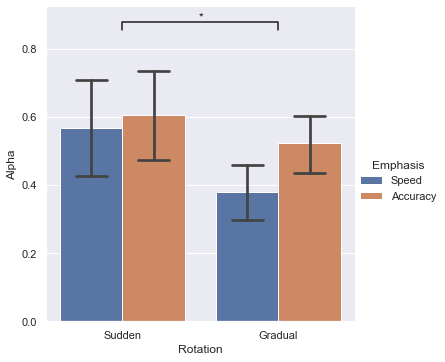

In [95]:
x1, x2 = 0, 1
y, h, col = alpha_means['Alpha'].max() - 0.2, 0.025, 'k'

sns.catplot(x = 'Rotation', y = 'Alpha', hue = 'Emphasis', data = alpha_means, kind = 'bar', capsize = 0.2)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


In [10]:
conc = pd.read_csv('conc.csv')

In [11]:
parameters_means['Model_Selected'] = 'Dual_Selected'

In [12]:
parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'

<ipython-input-12-d289fa70e1c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'


In [13]:
parameters_means['Dual_Selected'] = 1
parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0

<ipython-input-13-0fc71f62f964>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0


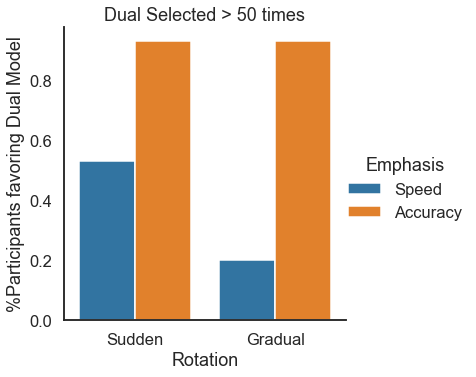

In [14]:
sns.set_context('talk')
sns.set_style('white')
cp = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'Dual_Selected', hue = 'Emphasis', kind = 'bar', ci = None)
plt.title('Dual Selected > 50 times')
cp.set_ylabels('%Participants favoring Dual Model')

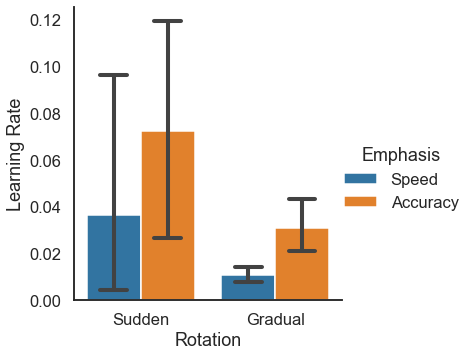

In [9]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2)
c.set(ylabel = 'Learning Rate')
#plt.title('Best fit by Single state')
#sns.boxplot(data = parameters_means,
#           x = 'Model_Selected', y = 'B', 
#            hue = 'Emphasis')
#plt.ylim((-0.2, 0.5))

In [42]:
model = smf.ols('Dual_Selected~Rotation*Emphasis', data = parameter_means[parameter_means['B']]).fit()
aov = sm.stats.anova_lm(model)
aov

KeyError: "None of [Float64Index([ 0.04283847986935048,  0.06279240528483808,  0.02603918295167823,\n               0.17899127966415612,  0.09962033003528861,   0.4680476273766781,\n               0.31933107549947715,  0.05978132827610681,   0.7910521960018442,\n                0.4517147664548228,   0.0681397784864444,  0.22082249475341648,\n              0.012341958133828103,  0.03443818985028595,  0.06345062864169426,\n                0.8295185954154907, 0.017881365274240103,   0.8629178115882645,\n              0.050835562610120316,  0.16098233780545373, 0.038292978187867616,\n                0.3457808909897438,  0.10650796391163048,   0.4442726208916362,\n               0.26278855922669486,  0.12134899963907711,  0.09966687773792587,\n               0.05394017037903433,   0.4475444123471095,  0.14930548370307936,\n              0.048075727068772306,   0.3074964695595582,  0.15406514205049943,\n               0.05698297773671179,  0.04875991671396991,   0.8546998790494442,\n                0.0920340720351489,  0.41021151035876224,    0.051215484288455,\n               0.13302647999195602,  0.39141722074698004,   0.8704243562987977,\n               0.16416206468619587,   0.5385704352485159,  0.08824770134237853,\n              0.057455634928114035, 0.057384288413874225,  0.08271684877889947,\n               0.27762637757501485,  0.33309752274574256, 0.053870200543525246,\n                 0.529029316661049,   0.6770287574000146,    0.649531154106255,\n               0.14698155532215873,   0.7273698491425329,   0.1572509204833082,\n                 0.809031128465258,  0.04489456852998236,\n                0.8894577102651301],\n             dtype='float64')] are in the [columns]"

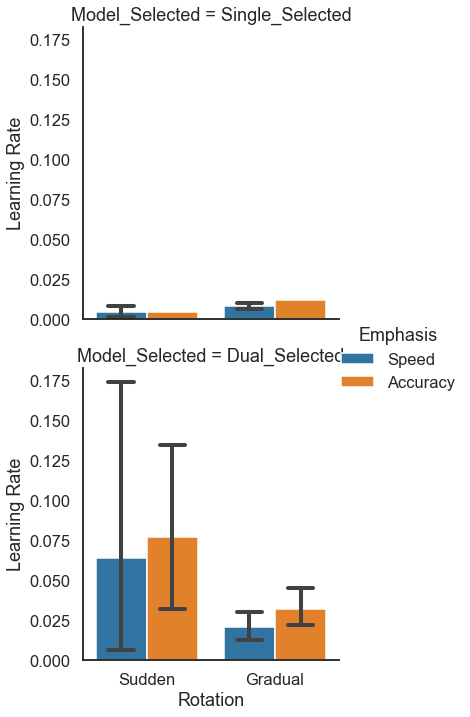

In [37]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2, row = 'Model_Selected')
#plt.title('Best fit by Single state')
#plt.hlines(y = np.max(parameters_means['B'][parameters_means['Model_Selected'] == 'Single_Selected']), 
#           xmin = -0.5, xmax = 2, color = 'black', linestyles='--')
c.set(ylabel = 'Learning Rate')

Text(0.5, 1.0, 'Best fit by Single state')

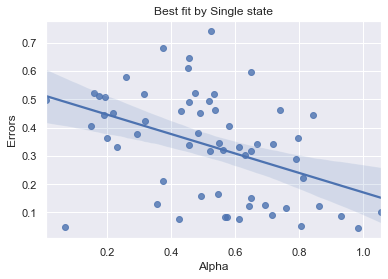

In [68]:
sns.regplot(data = parameters_means,
           x = 'Alpha', y = 'Errors')
plt.title('Best fit by Single state')


In [3]:
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))

curvatures_smooth = curvatures_smooth/90.0

In [4]:
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))

In [5]:
num_itr = 100
num_trials = 704
model_errors_fast = np.zeros((num_itr, 60, num_trials))
model_errors_slow = np.zeros((num_itr, 60, num_trials))
r_est = np.zeros((num_itr, 60, num_trials))
e_est = np.zeros((num_itr, 60, num_trials))
for i in range(num_itr):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:
            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant]  = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        else:
            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        

In [6]:
estimates_df = pd.DataFrame({'Participant_Id': np.tile(np.repeat(np.arange(60), 704), num_itr), 
                             'Trial': np.tile(np.arange(704), 60*num_itr), 
                             'Block': np.tile(np.repeat(np.arange(1, 12), 64), 60*num_itr), 
                             'E_est': np.ravel(e_est),
                             'R_est': np.ravel(r_est),
                             'Fast_est': np.ravel(model_errors_fast),
                             'Slow_est': np.ravel(model_errors_slow),
                             'Rotation': np.tile(np.repeat(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 704), 15*num_itr), 
                             'Emphasis': np.tile(np.repeat(['Speed', 'Accuracy'], 704), 30*num_itr), 
                             'slow_by_total': np.ravel(model_errors_slow)/(np.ravel(r_est) + 0.00001),
                             'fast_by_total': np.ravel(model_errors_fast)/(np.ravel(r_est) + 0.00001), 
                             'slow_by_fast': np.ravel(model_errors_slow)/(np.ravel(model_errors_fast) )

                            })
estimates_df['Slow_minus_Fast'] = estimates_df['Slow_est'] - estimates_df['Fast_est']


<ipython-input-6-6dd5bfeffe22>:12: RuntimeWarning: invalid value encountered in true_divide
  'slow_by_fast': np.ravel(model_errors_slow)/(np.ravel(model_errors_fast) )


In [7]:
estimate_means = estimates_df.groupby(['Participant_Id', 'Block', 'Rotation', 'Emphasis']).mean().reset_index()
estimate_means['Condition'] = estimate_means['Rotation'] + '_' + estimate_means['Emphasis']
estimate_means_melted = estimate_means.melt(['Participant_Id', 'Block', 'Rotation', 'Emphasis' ,'Trial',  'Condition'], var_name='Estimates')

In [18]:
estimate_sums = estimates_df.groupby(['Participant_Id', 'Block','Rotation', 'Emphasis']).sum().reset_index()
estimate_sums['Condition'] = estimate_sums['Rotation'] + '_' + estimate_sums['Emphasis']
estimate_sums_melted = estimate_sums.melt(['Participant_Id', 'Rotation', 'Emphasis' ,'Trial', 'Condition'], var_name='Estimates')

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,0.365437,0.365437,12.451368,0.000450
Emphasis,1.0,0.217890,0.217890,7.424067,0.006625
Rotation:Emphasis,1.0,0.240520,0.240520,8.195105,0.004348
Residual,596.0,17.492108,0.029349,NaN,NaN


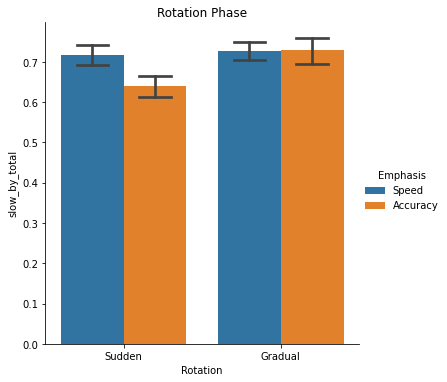

In [9]:
sns.catplot(x = 'Rotation', y = 'slow_by_total', hue = 'Emphasis',
            data = estimate_means[estimate_means['Block'] <= 10], kind = 'bar', capsize = 0.2)
plt.title('Rotation Phase')
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\slow_by_total_rotation.png', dpi = 600, bbox_inches = 'tight')
model = smf.ols('slow_by_total~Rotation*Emphasis', data = estimate_means[estimate_means['Block'] <= 10]).fit()
aov = sm.stats.anova_lm(model)
aov

Text(0.5, 1.0, 'Rotation Phase')

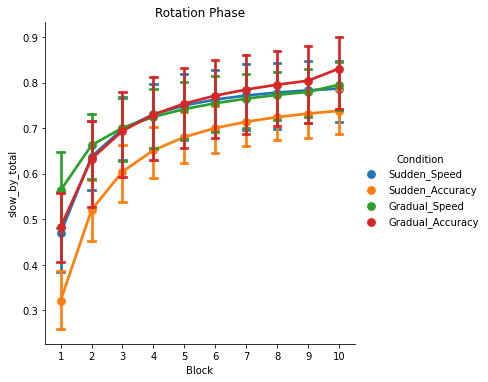

In [10]:
sns.catplot(x = 'Block', y = 'slow_by_total', hue = 'Condition', 
            data = estimate_means[estimate_means['Block'] < 11], kind = 'point', capsize = 0.2)
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\slow_by_total_individual_blocks.png', dpi = 600, bbox_inches = 'tight')
plt.title('Rotation Phase')
#plt.ylim((0, 1))

In [11]:
blockwise = np.reshape(np.array(estimate_means[estimate_means['Block'] <= 10]['slow_by_total']), (60, 10))
e = np.sum(blockwise, axis = 1)

final_block_errors = pd.DataFrame({'Participant_Id': (np.arange(60)), 
                                   'Washout_Errors': np.ravel(np.mean(curvatures_smooth[:, -1, :], 1)),  
                                   'slow_by_total': e
                                   #'slow_by_total': estimate_means[estimate_means['Block'] == 10]['slow_by_total']
                                  })

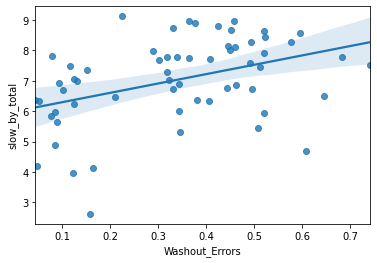

In [12]:
sns.regplot(data = final_block_errors,
           x = 'Washout_Errors', y = 'slow_by_total')
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\scatter_plot_slowbytotal_washout.png', dpi = 600, bbox_inches = 'tight')

In [116]:
final_block_errors.corr()

,Participant_Id,Errors,slow_by_total
Participant_Id,1.000000,-0.195003,-0.080942
Errors,-0.195003,1.000000,0.406420
slow_by_total,-0.080942,0.406420,1.000000


In [118]:
stat.pearsonr(final_block_errors['Errors'], final_block_errors['slow_by_total'])

(0.40641992733687293, 0.0012721154959184496)

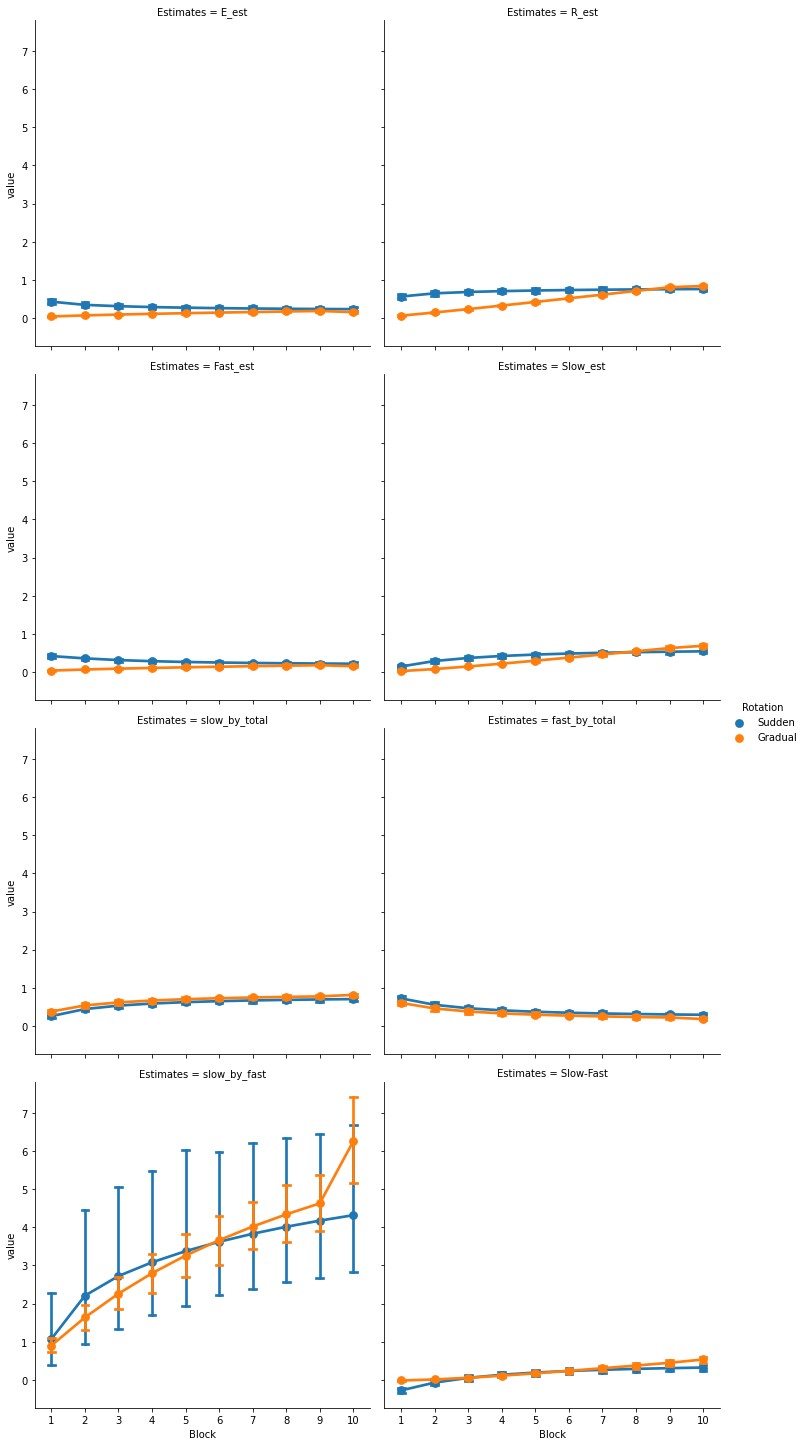

In [18]:
sns.catplot(x = 'Block', y = 'value', hue = 'Rotation', col = 'Estimates', col_wrap=2, 
            data = estimate_means_melted[estimate_means_melted['Block'] < 11], kind = 'point', capsize = 0.2)

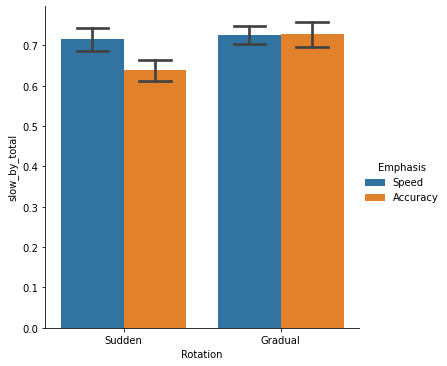

In [53]:
sns.catplot(data = estimate_means[estimate_means['Block'] < 11],
           x = 'Rotation', y = 'slow_by_total', hue = 'Emphasis', 
                kind = 'bar', capsize = 0.2)


PatsyError: Error evaluating factor: NameError: name 'fast_by_total' is not defined
    fast_by_total~Rotation*Emphasis
    ^^^^^^^^^^^^^

In [57]:
stat.binom_test(60, 100, 0.5)

0.05688793364098078